<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/Simulation_Results_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Target fill rate

In [ ]:
import pandas as pd
import os
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
demand_1y = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/demand_1y.csv")
demand_1y.head()

,Unnamed: 0,unique_id,date,sales,item_id,store_id,dept_id,cat_id,state_id,d
0,0,FOODS_1_145_CA_1,2015-01-29,5,FOODS_1_145,CA_1,FOODS_1,FOODS,CA,1462
1,1,FOODS_1_145_CA_1,2015-01-30,4,FOODS_1_145,CA_1,FOODS_1,FOODS,CA,1463
2,2,FOODS_1_145_CA_1,2015-01-31,2,FOODS_1_145,CA_1,FOODS_1,FOODS,CA,1464
3,3,FOODS_1_145_CA_1,2015-02-01,2,FOODS_1_145,CA_1,FOODS_1,FOODS,CA,1465
4,4,FOODS_1_145_CA_1,2015-02-02,0,FOODS_1_145,CA_1,FOODS_1,FOODS,CA,1466


In [ ]:
import pandas as pd

def compute_sigmas(demand_1y: pd.DataFrame, R: int = 1, L: int = 2,
                   pad_calendar: bool = False) -> pd.DataFrame:
    df = demand_1y.copy()
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['unique_id', 'date'])

    if pad_calendar:
        dfs = []
        for uid, g in df.groupby('unique_id', sort=False):
            cal = pd.DataFrame({'date': pd.date_range(g['date'].min(), g['date'].max(), freq='D')})
            gg = cal.merge(g[['date','sales']], on='date', how='left').fillna({'sales': 0})
            gg.insert(0, 'unique_id', uid)
            dfs.append(gg)
        df = pd.concat(dfs, ignore_index=True)

    # standard diviation
    sigma_daily = (
        df.groupby('unique_id')['sales']
          .std(ddof=1)
          .rename('sigma_daily')
    )

    # sigma_R
    W_R = int(R)
    sum_R = (
        df.groupby('unique_id', group_keys=False)['sales']
          .rolling(W_R, min_periods=W_R)
          .sum()
          .reset_index(level=0, drop=True)
    )
    df_R = df.assign(sum_R=sum_R)
    sigma_R = (
        df_R.groupby('unique_id')['sum_R']
            .std(ddof=1)
            .rename('sigma_R')
    )

    #  sigma_{R+L}
    W_RL = int(R + L)
    sum_RL = (
        df.groupby('unique_id', group_keys=False)['sales']
          .rolling(W_RL, min_periods=W_RL)
          .sum()
          .reset_index(level=0, drop=True)
    )
    df_RL = df.assign(sum_RL=sum_RL)
    sigma_RL = (
        df_RL.groupby('unique_id')['sum_RL']
             .std(ddof=1)
             .rename('sigma_RL')
    )

    # summary
    sigmas = (
        pd.concat([sigma_daily, sigma_R, sigma_RL], axis=1)
          .fillna(0.0)
          .reset_index()
          .sort_values('unique_id')
    )
    return sigmas

sigmas_159 = compute_sigmas(demand_1y, R=1, L=2, pad_calendar=False)
print(sigmas_159.shape)
display(sigmas_159.head())

(159, 4)


,unique_id,sigma_daily,sigma_R,sigma_RL
0,FOODS_1_145_CA_1,1.843766,1.843766,3.512606
1,FOODS_1_145_CA_3,2.038032,2.038032,3.553951
2,FOODS_1_145_CA_4,1.248048,1.248048,2.156178
3,FOODS_1_145_TX_1,1.332623,1.332623,2.338831
4,FOODS_1_145_TX_2,1.442422,1.442422,2.532660


In [ ]:
# R expected demand
mu_R = (
    demand_1y
    .groupby('unique_id')['sales']
    .mean()
    .rename('mu_R')
    .reset_index()
)

display(mu_R.head())

,unique_id,mu_R
0,FOODS_1_145_CA_1,1.846575
1,FOODS_1_145_CA_3,1.783562
2,FOODS_1_145_CA_4,0.991781
3,FOODS_1_145_TX_1,1.134247
4,FOODS_1_145_TX_2,1.213699


In [ ]:
# Calculate fill rate
import numpy as np
import pandas as pd
R, L = 1, 2
RL = R + L                   # 3
Gz = 0.021                   # z=1.65 -> G(z)≈0.021
eps = 1e-8
df_target = (
    mu_R.merge(sigmas_159[['unique_id','sigma_RL']], on='unique_id', how='inner')
        .copy()
)

# Calculate alpha_fr and target fill rate
df_target['alpha_fr'] = Gz * df_target['sigma_RL'] / (df_target['mu_R'] + eps)
df_target['alpha_fr'] = df_target['alpha_fr'].clip(0, 1)
df_target['target_fill_rate'] = 1.0 - df_target['alpha_fr']
df_target.loc[df_target['mu_R'] <= eps, 'target_fill_rate'] = np.nan

df_target = df_target[['unique_id','mu_R','sigma_RL','alpha_fr','target_fill_rate']]
display(df_target.head())
print("rows:", len(df_target))

,unique_id,mu_R,sigma_RL,alpha_fr,target_fill_rate
0,FOODS_1_145_CA_1,1.846575,3.512606,0.039947,0.960053
1,FOODS_1_145_CA_3,1.783562,3.553951,0.041845,0.958155
2,FOODS_1_145_CA_4,0.991781,2.156178,0.045655,0.954345
3,FOODS_1_145_TX_1,1.134247,2.338831,0.043302,0.956698
4,FOODS_1_145_TX_2,1.213699,2.532660,0.043821,0.956179


rows: 159


In [ ]:
mean_target = df_target['target_fill_rate'].mean()
median_target = df_target['target_fill_rate'].median()

print("Mean target fill rate:", round(mean_target, 4))
print("Median target fill rate:", round(median_target, 4))

Mean target fill rate: 0.9457
Median target fill rate: 0.949


In [ ]:
df_target.to_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/df_target.csv", index=False)

# Comparison

In [ ]:
df_target = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/df_target.csv")
df_target.head()

,unique_id,mu_R,sigma_RL,alpha_fr,target_fill_rate
0,FOODS_1_145_CA_1,1.846575,3.512606,0.039947,0.960053
1,FOODS_1_145_CA_3,1.783562,3.553951,0.041845,0.958155
2,FOODS_1_145_CA_4,0.991781,2.156178,0.045655,0.954345
3,FOODS_1_145_TX_1,1.134247,2.338831,0.043302,0.956698
4,FOODS_1_145_TX_2,1.213699,2.532660,0.043821,0.956179


In [ ]:
kpi_ml_159 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/kpi_ml_159.csv")
kpi_baseline_159 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/Baseline_Forecast/kpi_baseline_159.csv")
print(kpi_ml_159.head())
print(kpi_baseline_159.head())
print(kpi_ml_159.shape)
print(kpi_baseline_159.shape)

   Unnamed: 0         unique_id   model  n_days  orders  avg_order_qty  \
0           0  FOODS_1_145_CA_1  ML_ens     359     254       2.606299   
1           1  FOODS_1_145_CA_3  ML_ens     359     230       2.769565   
2           2  FOODS_1_145_CA_4  ML_ens     359     195       1.851282   
3           3  FOODS_1_145_TX_1  ML_ens     359     199       2.020101   
4           4  FOODS_1_145_TX_2  ML_ens     359     201       2.154229   

   fill_rate       PSL       CSL  turnover_daily  
0   0.987897  0.991643  0.980237        0.239060  
1   0.984326  0.986072  0.956332        0.216491  
2   0.986111  0.988858  0.969231        0.225989  
3   0.997512  0.997214  0.989899        0.207967  
4   0.986207  0.991643  0.970149        0.185422  
          unique_id           model  n_days  orders  avg_order_qty  fill_rate  \
0  FOODS_1_145_CA_1       AutoARIMA     361     252       2.638889   0.986446   
1  FOODS_1_145_CA_1  CrostonClassic     361     249       2.674699   0.986446   
2  FOO

In [ ]:
# Merge 2 models
kpi_ml_159_clean = kpi_ml_159.drop(columns=['Unnamed: 0'], errors='ignore')
kpi_base_159_clean = kpi_baseline_159.drop(columns=['Unnamed: 0'], errors='ignore')

kpi_ml_159_clean = kpi_ml_159_clean.assign(source='ML')
kpi_base_159_clean = kpi_base_159_clean.assign(source='Baseline')

kpi_all_159 = pd.concat([kpi_ml_159_clean, kpi_base_159_clean], ignore_index=True)

kpi_all_159 = kpi_all_159.sort_values(['unique_id','source','model']).reset_index(drop=True)
kpi_all_159_clean = kpi_all_159.drop(columns=['n_days'])
display(kpi_all_159_clean.head(10))
print("TOTAL rows:", kpi_all_159_clean.shape[0])


,unique_id,model,orders,avg_order_qty,fill_rate,PSL,CSL,turnover_daily,source
0,FOODS_1_145_CA_1,AutoARIMA,252,2.638889,0.986446,0.986150,0.964143,0.246657,Baseline
1,FOODS_1_145_CA_1,CrostonClassic,249,2.674699,0.986446,0.983380,0.955645,0.241630,Baseline
2,FOODS_1_145_CA_1,SeasonalNaive,185,3.578378,0.993976,0.991690,0.967568,0.175290,Baseline
3,FOODS_1_145_CA_1,Theta,248,2.681452,0.984940,0.980609,0.947368,0.242868,Baseline
4,FOODS_1_145_CA_1,ML_ens,254,2.606299,0.987897,0.991643,0.980237,0.239060,ML
5,FOODS_1_145_CA_3,AutoARIMA,243,2.629630,0.984399,0.988920,0.966942,0.213028,Baseline
6,FOODS_1_145_CA_3,CrostonClassic,243,2.625514,0.984399,0.988920,0.966942,0.204662,Baseline
7,FOODS_1_145_CA_3,SeasonalNaive,180,3.533333,1.000000,1.000000,1.000000,0.144045,Baseline
8,FOODS_1_145_CA_3,Theta,241,2.647303,0.984399,0.988920,0.966667,0.211621,Baseline
9,FOODS_1_145_CA_3,ML_ens,230,2.769565,0.984326,0.986072,0.956332,0.216491,ML


TOTAL rows: 795


In [ ]:
kpi_all_159_clean.to_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/kpi_all_159_clean.csv", index=False)

In [ ]:
kpi_all_159_clean = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Supervised Project/kpi_all_159_clean.csv")
kpi_all_159_clean.head()

,unique_id,model,orders,avg_order_qty,fill_rate,PSL,CSL,turnover_daily,source
0,FOODS_1_145_CA_1,AutoARIMA,252,2.638889,0.986446,0.986150,0.964143,0.246657,Baseline
1,FOODS_1_145_CA_1,CrostonClassic,249,2.674699,0.986446,0.983380,0.955645,0.241630,Baseline
2,FOODS_1_145_CA_1,SeasonalNaive,185,3.578378,0.993976,0.991690,0.967568,0.175290,Baseline
3,FOODS_1_145_CA_1,Theta,248,2.681452,0.984940,0.980609,0.947368,0.242868,Baseline
4,FOODS_1_145_CA_1,ML_ens,254,2.606299,0.987897,0.991643,0.980237,0.239060,ML


In [ ]:
# Overall outcomes
# For service classes (fill_rate/PSL/CSL), use mean (intuitively measures overall service level)
# For frequency/batch/turnover (orders/avg_order_qty/turnover_daily), use median (more robust to skewness)
import pandas as pd
import numpy as np

df = kpi_all_159_clean.copy()

need = {'model','orders','avg_order_qty','fill_rate','PSL','CSL','turnover_daily'}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"kpi_all_159_clean missing columns: {missing}")

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

agg = (df.groupby('model')
         .agg(
             orders_mean        = ('orders','mean'),
             orders_median      = ('orders','median'),
             orders_IQR         = ('orders', iqr),

             avgqty_mean        = ('avg_order_qty','mean'),
             avgqty_median      = ('avg_order_qty','median'),
             avgqty_IQR         = ('avg_order_qty', iqr),

             fill_mean          = ('fill_rate','mean'),
             fill_median        = ('fill_rate','median'),
             fill_IQR           = ('fill_rate', iqr),

             psl_mean           = ('PSL','mean'),
             psl_median         = ('PSL','median'),
             psl_IQR            = ('PSL', iqr),

             csl_mean           = ('CSL','mean'),
             csl_median         = ('CSL','median'),
             csl_IQR            = ('CSL', iqr),

             turn_mean          = ('turnover_daily','mean'),
             turn_median        = ('turnover_daily','median'),
             turn_IQR           = ('turnover_daily', iqr),

             n_series           = ('model','count')
         )
         .sort_index()
      )

preferred = pd.DataFrame(index=agg.index)
preferred['orders']         = agg['orders_median']
preferred['avg_order_qty']  = agg['avgqty_median']
preferred['fill_rate']      = agg['fill_mean']
preferred['PSL']            = agg['psl_mean']
preferred['CSL']            = agg['csl_mean']
preferred['turnover_daily'] = agg['turn_median']
preferred['n_series']       = agg['n_series']

preferred = preferred.round({
    'orders':0, 'avg_order_qty':3, 'fill_rate':4, 'PSL':4, 'CSL':4, 'turnover_daily':3
})
agg_rounded = agg.copy().round(4)

print("Per-model preferred summary (service = mean, freq/qty/turnover = median):")
display(preferred)
print("\nFull stats (mean/median/IQR for each metric):")
display(agg_rounded)



Per-model preferred summary (service = mean, freq/qty/turnover = median):


,orders,avg_order_qty,fill_rate,PSL,CSL,turnover_daily,n_series
model,,,,,,,
AutoARIMA,216.0,2.820,0.9617,0.9852,0.9514,0.212,159
CrostonClassic,217.0,2.754,0.9648,0.9871,0.9554,0.192,159
ML_ens,209.0,2.811,0.9708,0.9886,0.9604,0.216,159
SeasonalNaive,163.0,3.578,0.9767,0.9905,0.9645,0.150,159
Theta,213.0,2.815,0.9632,0.9849,0.9511,0.208,159



Full stats (mean/median/IQR for each metric):


,orders_mean,orders_median,orders_IQR,avgqty_mean,avgqty_median,avgqty_IQR,fill_mean,fill_median,fill_IQR,psl_mean,psl_median,psl_IQR,csl_mean,csl_median,csl_IQR,turn_mean,turn_median,turn_IQR,n_series
model,,,,,,,,,,,,,,,,,,,
AutoARIMA,213.3019,216.0,114.0,6.6449,2.8202,4.0101,0.9617,0.9809,0.0454,0.9852,0.9889,0.0166,0.9514,0.9609,0.0603,0.2271,0.2121,0.1053,159
CrostonClassic,214.9874,217.0,116.5,6.5886,2.7537,3.9800,0.9648,0.9844,0.0359,0.9871,0.9917,0.0111,0.9554,0.9676,0.0498,0.2209,0.1918,0.1017,159
ML_ens,207.7610,209.0,112.0,6.7654,2.8106,4.1683,0.9708,0.9875,0.0333,0.9886,0.9916,0.0139,0.9604,0.9714,0.0494,0.2380,0.2160,0.1266,159
SeasonalNaive,174.0377,163.0,90.5,7.7137,3.5784,5.0217,0.9767,0.9913,0.0284,0.9905,0.9945,0.0111,0.9645,0.9748,0.0460,0.1748,0.1495,0.0993,159
Theta,212.3962,213.0,110.5,6.6785,2.8153,4.1802,0.9632,0.9810,0.0479,0.9849,0.9889,0.0166,0.9511,0.9578,0.0565,0.2250,0.2079,0.1087,159


In [ ]:
pref = preferred.copy()
if pref.index.name is not None or isinstance(pref.index, pd.Index):
    pref = pref.rename(index={'ML_ens': 'ML'})
    order = ['ML'] + [m for m in pref.index.tolist() if m != 'ML']
    pref = pref.loc[order]

elif 'model' in pref.columns:
    pref['model'] = pref['model'].replace({'ML_ens': 'ML'})
    other = pref.loc[pref['model'] != 'ML']
    mlrow = pref.loc[pref['model'] == 'ML']
    pref = pd.concat([mlrow, other], ignore_index=True)

display(pref)

,orders,avg_order_qty,fill_rate,PSL,CSL,turnover_daily,n_series
model,,,,,,,
ML,209.0,2.811,0.9708,0.9886,0.9604,0.216,159
AutoARIMA,216.0,2.820,0.9617,0.9852,0.9514,0.212,159
CrostonClassic,217.0,2.754,0.9648,0.9871,0.9554,0.192,159
SeasonalNaive,163.0,3.578,0.9767,0.9905,0.9645,0.150,159
Theta,213.0,2.815,0.9632,0.9849,0.9511,0.208,159


**Scatter Plot**

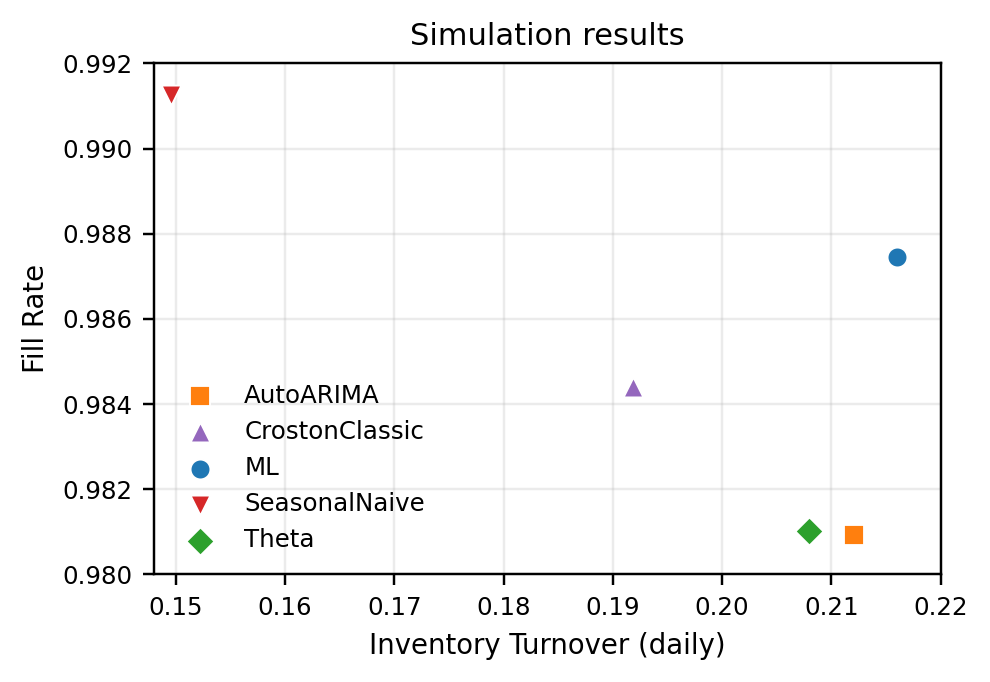

In [ ]:
# scatter: Fill rate vs Inventory Turnover
import pandas as pd
import matplotlib.pyplot as plt

df = kpi_all_159_clean.copy()
df['model'] = df['model'].replace({'ML_ens': 'ML'})

AGG = 'median'
per_model = (df.groupby('model', as_index=False)
               .agg({'fill_rate': AGG, 'turnover_daily': AGG})
            )

color_map  = {'ML':'#1f77b4','AutoARIMA':'#ff7f0e','Theta':'#2ca02c',
              'CrostonClassic':'#9467bd','SeasonalNaive':'#d62728'}
marker_map = {'ML':'o','AutoARIMA':'s','Theta':'D',
              'CrostonClassic':'^','SeasonalNaive':'v'}
fig, ax = plt.subplots(figsize=(4.6, 3.2), dpi=220)

for _, r in per_model.iterrows():
    m = r['model']
    ax.scatter(r['turnover_daily'], r['fill_rate'],
               s=42, marker=marker_map.get(m,'o'),
               color=color_map.get(m,'#333333'),
               edgecolor='white', linewidth=0.6, zorder=3,
               label=m)

use_annotations = False

if use_annotations:
    offsets = {
        'ML': (6, 2),
        'AutoARIMA': (6, -6),
        'Theta': (-6, -6),
        'CrostonClassic': (6, 0),
        'SeasonalNaive': (0, -10),
    }
    for _, r in per_model.iterrows():
        m = r['model']
        dx, dy = offsets.get(m, (5, 3))
        ax.annotate(m, (r['turnover_daily'], r['fill_rate']),
                    xytext=(dx, dy), textcoords='offset points',
                    fontsize=8, color=color_map.get(m,'#333333'),
                    zorder=4)
else:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc='lower left', fontsize=8, frameon=False)


ax.set_xlim(0.148, 0.22)
ax.set_ylim(0.9800, 0.9920)

ax.set_title('Simulation results', fontsize=10, pad=6)
ax.set_xlabel('Inventory Turnover (daily)', fontsize=9)
ax.set_ylabel('Fill Rate', fontsize=9)
ax.grid(alpha=0.25, zorder=0)
ax.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

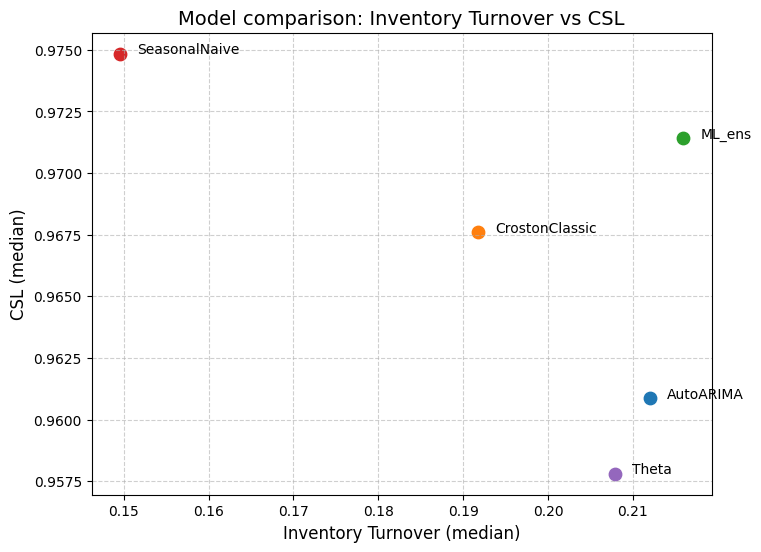

,model,median_turnover,median_CSL
0,AutoARIMA,0.212059,0.960870
1,CrostonClassic,0.191803,0.967593
2,ML_ens,0.215976,0.971429
3,SeasonalNaive,0.149529,0.974843
4,Theta,0.207946,0.957806


In [ ]:
# CSL vs Inventory turnover
import matplotlib.pyplot as plt

agg_scatter = (
    kpi_all_159_clean
    .groupby('model')
    .agg(
        median_turnover=('turnover_daily','median'),
        median_CSL=('CSL','median')
    )
    .reset_index()
)

plt.figure(figsize=(8,6))
for _, row in agg_scatter.iterrows():
    plt.scatter(row['median_turnover'], row['median_CSL'], s=80)
    plt.text(row['median_turnover']+0.002, row['median_CSL'], row['model'], fontsize=10)

plt.xlabel("Inventory Turnover (median)", fontsize=12)
plt.ylabel("CSL (median)", fontsize=12)
plt.title("Model comparison: Inventory Turnover vs CSL", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

display(agg_scatter)

**Store**

In [ ]:
import re
import pandas as pd
import numpy as np

df = kpi_all_159_clean.copy()
df['model'] = df['model'].replace({'ML_ens': 'ML'})

if 'store' not in df.columns:
    if 'store_id' in df.columns:
        df['store'] = df['store_id'].astype(str)
    else:
        uid = df['unique_id'].astype(str)

        pattern = re.compile(r'([A-Za-z]{2,})[_\-]?(\d{1,2})$')

        def extract_store(u: str) -> str:
            last = re.split(r'[\/\|\.\-_\s]+', u)[-1]
            m = pattern.search(last) or pattern.search(u)
            if m:
                state = m.group(1).upper()
                num = str(int(m.group(2)))
                return f"{state}_{num}"
            for seg in re.split(r'[\/\|\.\-_\s]+', u):
                if re.fullmatch(r'[A-Za-z]{2,}_\d{1,2}', seg):
                    s, n = seg.split('_', 1)
                    return f"{s.upper()}_{int(n)}"
            return 'UNKNOWN'

        df['store'] = uid.map(extract_store)

need = {'store', 'model', 'unique_id',
        'orders', 'avg_order_qty', 'fill_rate', 'PSL', 'CSL', 'turnover_daily'}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"kpi_all_159_clean missing columns: {missing}")
agg_funcs = {
    'orders'        : 'median',
    'avg_order_qty' : 'median',
    'turnover_daily': 'median',
    'fill_rate'     : 'mean',
    'PSL'           : 'mean',
    'CSL'           : 'mean',
    'unique_id'     : 'count',   # n_series
}

per_store_model = (df.groupby(['store','model'], as_index=False)
                     .agg(agg_funcs)
                     .rename(columns={'unique_id':'n_series'}))

model_order = ['ML', 'AutoARIMA', 'Theta', 'CrostonClassic', 'SeasonalNaive']
per_store_model['model'] = pd.Categorical(per_store_model['model'],
                                          categories=model_order, ordered=True)
per_store_model = per_store_model.sort_values(['store','model']).reset_index(drop=True)

round_map = {
    'orders': 0,
    'avg_order_qty': 3,
    'turnover_daily': 3,
    'fill_rate': 4,
    'PSL': 4,
    'CSL': 4
}
per_store_model_rounded = per_store_model.copy()
for c, r in round_map.items():
    per_store_model_rounded[c] = per_store_model_rounded[c].round(r)

display(per_store_model_rounded.head(15))


,store,model,orders,avg_order_qty,turnover_daily,fill_rate,PSL,CSL,n_series
0,CA_1,ML,218.0,2.708,0.239,0.9800,0.9890,0.9653,20
1,CA_1,AutoARIMA,224.0,2.747,0.236,0.9722,0.9856,0.9583,20
2,CA_1,Theta,225.0,2.792,0.236,0.9739,0.9852,0.9568,20
3,CA_1,CrostonClassic,225.0,2.714,0.230,0.9770,0.9888,0.9641,20
4,CA_1,SeasonalNaive,173.0,3.624,0.173,0.9850,0.9902,0.9674,20
5,CA_3,ML,239.0,4.938,0.246,0.9749,0.9903,0.9705,20
6,CA_3,AutoARIMA,244.0,4.853,0.238,0.9712,0.9877,0.9636,20
7,CA_3,Theta,242.0,5.012,0.241,0.9717,0.9857,0.9594,20
8,CA_3,CrostonClassic,243.0,4.695,0.238,0.9669,0.9846,0.9561,20
9,CA_3,SeasonalNaive,190.0,6.118,0.187,0.9840,0.9917,0.9720,20


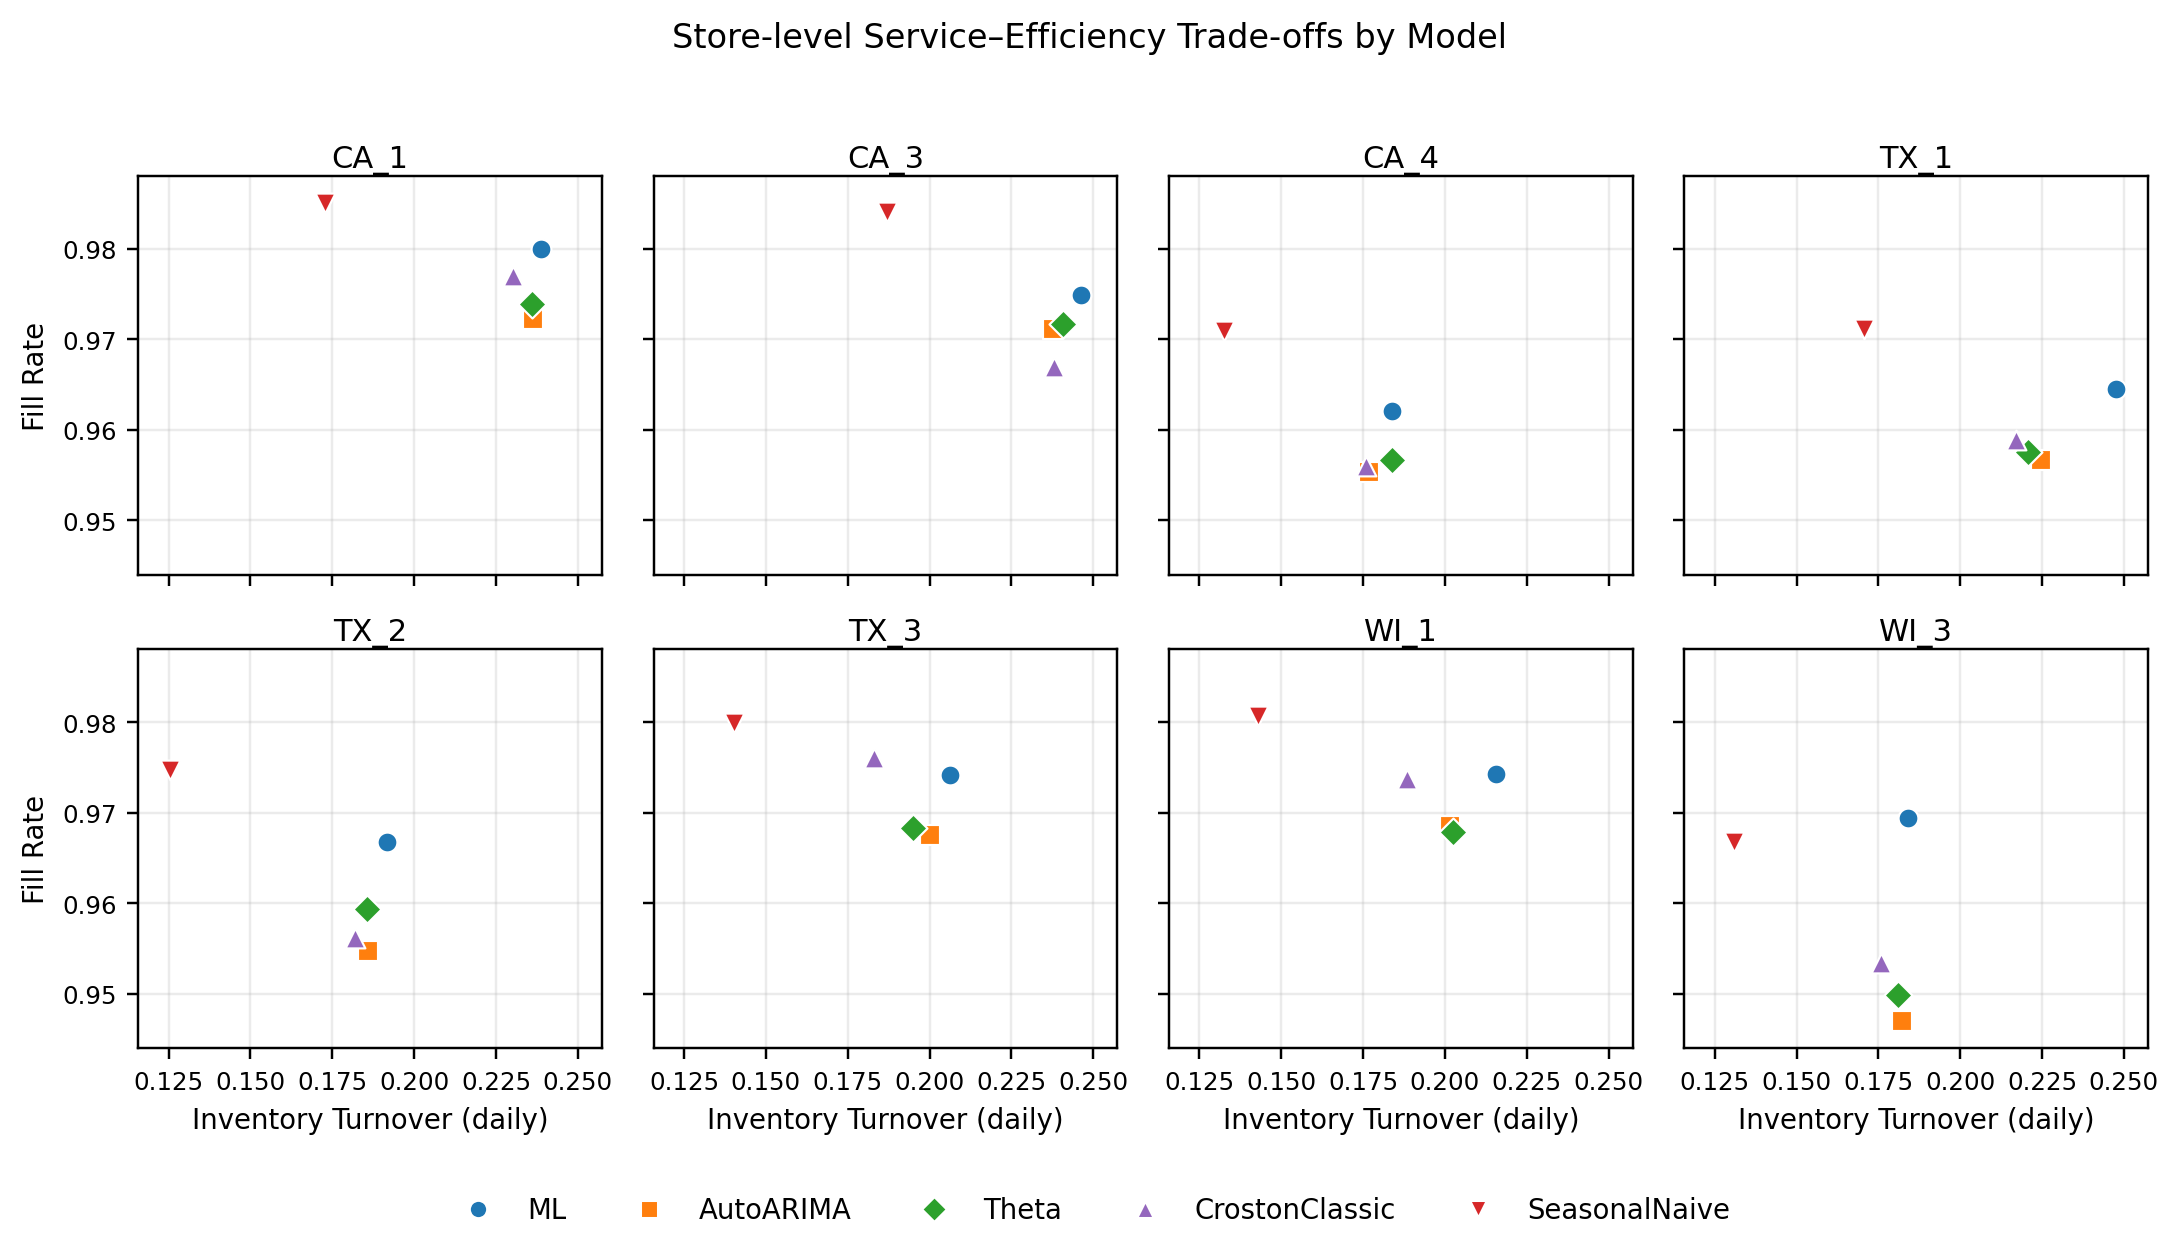

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

d = per_store_model

xmin, xmax = d['turnover_daily'].min(), d['turnover_daily'].max()
ymin, ymax = d['fill_rate'].min(), d['fill_rate'].max()
pad_x = (xmax - xmin) * 0.08 or 0.005
pad_y = (ymax - ymin) * 0.08 or 0.002
xlim = (xmin - pad_x, xmax + pad_x)
ylim = (ymin - pad_y, ymax + pad_y)

fig, axes = plt.subplots(2, 4, figsize=(10, 5.6), dpi=220, sharex=True, sharey=True)
axes = axes.ravel()

model_order = ['ML', 'AutoARIMA', 'Theta', 'CrostonClassic', 'SeasonalNaive']
color_map  = {'ML':'#1f77b4','AutoARIMA':'#ff7f0e','Theta':'#2ca02c','CrostonClassic':'#9467bd','SeasonalNaive':'#d62728'}
marker_map = {'ML':'o','AutoARIMA':'s','Theta':'D','CrostonClassic':'^','SeasonalNaive':'v'}

stores = sorted(d['store'].unique())
for i, store in enumerate(stores):
    ax = axes[i]
    g = d[d['store']==store].set_index('model')
    for m in model_order:
        if m in g.index:
            ax.scatter(g.loc[m,'turnover_daily'], g.loc[m,'fill_rate'],
                       s=42, marker=marker_map[m], color=color_map[m],
                       edgecolor='white', linewidth=0.7, zorder=3)
    ax.set_title(store, fontsize=10, pad=3)
    ax.grid(alpha=.25); ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    if i % 4 == 0: ax.set_ylabel('Fill Rate', fontsize=9)
    if i // 4 == 1: ax.set_xlabel('Inventory Turnover (daily)', fontsize=9)
    ax.tick_params(labelsize=8)

handles = [plt.Line2D([0],[0], marker=marker_map[m], color='w',
                      markerfacecolor=color_map[m], markeredgecolor='white',
                      markersize=6, label=m) for m in model_order]
fig.legend(handles=handles, loc='lower center', ncol=5, frameon=False, fontsize=9)

fig.suptitle('Store-level Service–Efficiency Trade-offs by Model', fontsize=11, y=0.99)
plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.show()

**Demand Type**

In [ ]:
demand_typ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/Baseline_Forecast/df_long_1ytest.csv')
display(demand_typ.head())

,Unnamed: 0,unique_id,item_id,store_id,state_id,dept_id,d,date,sales,ADI,CV2,Demand_Type
0,0,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,883,2013-06-29,0,2.412358,0.45293,Intermittent
1,1,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,884,2013-06-30,0,2.412358,0.45293,Intermittent
2,2,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,885,2013-07-01,0,2.412358,0.45293,Intermittent
3,3,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,886,2013-07-02,3,2.412358,0.45293,Intermittent
4,4,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,887,2013-07-03,2,2.412358,0.45293,Intermittent


In [ ]:
# ==== 0) Imports ====
import pandas as pd
import numpy as np

# Assumes you already have:
#   kpi_all_159_clean  (simulation KPIs; has 'unique_id', 'model', orders/qty/fill_rate/PSL/CSL/turnover_daily)
#   demand_typ         (daily or series-level table; has 'unique_id', 'Demand_Type', possibly multiple rows per id)

# ==== 1) Base tables & naming ====
kpi = kpi_all_159_clean.copy()

# Normalize model naming
kpi['model'] = kpi['model'].replace({'ML_ens': 'ML'})

# ==== 2) Build a unique_id -> Demand_Type map ====
dt = demand_typ[['unique_id', 'Demand_Type']].dropna(subset=['unique_id', 'Demand_Type']).copy()

# If demand_typ is daily, reduce to one type per unique_id (use mode; fallback to first)
type_map = (
    dt.groupby('unique_id', observed=True)['Demand_Type']
      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
      .reset_index()
)

# ==== 3) Merge into KPI ====
kpi_typed = kpi.merge(type_map, on='unique_id', how='left')

# Drop rows without a type (if any)
missing = int(kpi_typed['Demand_Type'].isna().sum())
if missing > 0:
    print(f"[WARN] Dropping {missing} rows without Demand_Type after merge.")
    kpi_typed = kpi_typed.dropna(subset=['Demand_Type'])

# ==== 4) Order for display (optional) ====
type_order  = ['Smooth', 'Erratic', 'Intermittent', 'Lumpy']  # adjust to your taxonomy if needed
model_order = ['ML', 'AutoARIMA', 'Theta', 'CrostonClassic', 'SeasonalNaive']

kpi_typed['Demand_Type'] = pd.Categorical(kpi_typed['Demand_Type'], categories=type_order, ordered=True)
kpi_typed['model']       = pd.Categorical(kpi_typed['model'], categories=model_order, ordered=True)

# ==== 5) Type × Model aggregation (mixed-statistics) ====
agg_funcs = {
    'orders'        : 'median',  # frequency -> skewed, use median
    'avg_order_qty' : 'median',  # batch size -> skewed, use median
    'turnover_daily': 'median',  # efficiency -> sensitive to outliers, use median
    'fill_rate'     : 'mean',    # service over horizon -> mean
    'PSL'           : 'mean',
    'CSL'           : 'mean',
    'unique_id'     : 'count',   # n_series
}

per_type_model = (
    kpi_typed
      .groupby(['Demand_Type', 'model'], observed=True, as_index=False)
      .agg(agg_funcs)
      .rename(columns={'unique_id': 'n_series'})
      .sort_values(['Demand_Type', 'model'])
      .reset_index(drop=True)
)

# Nicely rounded copy for reporting
round_map = {
    'orders'        : 0,
    'avg_order_qty' : 3,
    'turnover_daily': 3,
    'fill_rate'     : 4,
    'PSL'           : 4,
    'CSL'           : 4
}
per_type_model_report = per_type_model.copy()
for col, dec in round_map.items():
    per_type_model_report[col] = per_type_model_report[col].round(dec)

print("\n=== Demand Type × Model summary (mixed statistics) ===")
print(per_type_model_report)

# ==== 6) Best model per demand type (by service first, then efficiency) ====
best_by_type = (
    per_type_model
      .sort_values(['Demand_Type', 'fill_rate', 'turnover_daily'], ascending=[True, False, False])
      .groupby('Demand_Type', observed=True)
      .head(1)[['Demand_Type', 'model', 'fill_rate', 'turnover_daily', 'n_series']]
      .reset_index(drop=True)
      .copy()
)
# Proper rounding via dict (avoid the .round([4,3]) error)
best_by_type = best_by_type.round({'fill_rate': 4, 'turnover_daily': 3})

print("\n=== Best model within each Demand Type (by Fill Rate, then Turnover) ===")
print(best_by_type)

# ==== 7) (Optional) Export ====
# per_type_model_report.to_csv('kpi_by_demand_type_model.csv', index=False)
# best_by_type.to_csv('best_model_per_demand_type.csv', index=False)


=== Demand Type × Model summary (mixed statistics) ===
     Demand_Type           model  orders  avg_order_qty  turnover_daily  \
0         Smooth              ML   342.0         11.682           0.402   
1         Smooth       AutoARIMA   353.0         11.506           0.408   
2         Smooth           Theta   352.0         11.489           0.399   
3         Smooth  CrostonClassic   352.0         11.489           0.397   
4         Smooth   SeasonalNaive   317.0         12.278           0.362   
5        Erratic              ML   226.0          5.610           0.240   
6        Erratic       AutoARIMA   231.0          5.458           0.224   
7        Erratic           Theta   231.0          5.423           0.222   
8        Erratic  CrostonClassic   234.0          5.229           0.219   
9        Erratic   SeasonalNaive   191.0          6.736           0.176   
10  Intermittent              ML   168.0          1.831           0.177   
11  Intermittent       AutoARIMA   175.0    

In [ ]:
per_type_model_report.head(20)

,Demand_Type,model,orders,avg_order_qty,turnover_daily,fill_rate,PSL,CSL,n_series
0,Smooth,ML,342.0,11.682,0.402,0.9943,0.9956,0.9904,32
1,Smooth,AutoARIMA,353.0,11.506,0.408,0.9927,0.9949,0.9899,32
2,Smooth,Theta,352.0,11.489,0.399,0.9927,0.9943,0.9886,32
3,Smooth,CrostonClassic,352.0,11.489,0.397,0.9967,0.9960,0.9917,32
4,Smooth,SeasonalNaive,317.0,12.278,0.362,0.9917,0.9943,0.9859,32
5,Erratic,ML,226.0,5.610,0.240,0.9925,0.9907,0.9748,12
6,Erratic,AutoARIMA,231.0,5.458,0.224,0.9794,0.9827,0.9582,12
7,Erratic,Theta,231.0,5.423,0.222,0.9800,0.9822,0.9583,12
8,Erratic,CrostonClassic,234.0,5.229,0.219,0.9825,0.9841,0.9638,12
9,Erratic,SeasonalNaive,191.0,6.736,0.176,0.9864,0.9880,0.9646,12
